<a href="https://colab.research.google.com/github/XavierCachan/moduleIA_S4/blob/P3_Temp/Neurone_artificiel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Retour vers la partie 2 : Caractérisation d'une batterie par optimisation](https://colab.research.google.com/drive/1JXGgboVAfwCTm1tow6axvQS3vtgH3vH3#scrollTo=4B-_OgfjO2Ab)

# **TP IA Partie 3 - Caractérisation d'une batterie par un neurone artificiel - IUT de Cachan GEII2 2024**
XM - Février 2024 - Version : 0.5

-----

Note : Pour avancer dans ce notebook, il suffit d'exécuter (petite flèche), ou compléter puis exécuter, les différents blocs de code placés ci-dessous.

Pour cette troisième partie, nous allons traiter le même problème de carctérisation de batterie que dans la partie 2, mais cette fois en utilisant les modules Python permettant de créer des neurones artificiels. Le modèle recherché est donc toujours **U_bat = E - Ri * I_bat**  

**1. Import des modules nécessaires pour les calculs et l'affichage**

In [2]:
import pandas as pd               # Module pour la construction d'un réseau de neurones
import tensorflow as tf           # TensorFlow est LE module utilisé pour l'entrainement d'un réseau de neurones
import numpy as np                # Module de fonctions mathématiques
import matplotlib.pyplot as plt   # Module pour l'affichage

**2. Fabrication des signaux de mesure de tension U_mes (ce sont les mêmes codes que dans la Partie 2)**

In [ ]:
N = 40                           # Nombre de mesures
I_bat = np.linspace(0,10,num=N)  # Fabrication d'un vecteur de N points régulièrement espacés entre 0 et 10 (0, ..., 10 Ampères)

# Définition de la fonction mathématique théorique. Le modèle que l'on va essayer de retrouver automatiquement est U_bat = E - Ri * I_bat
Ri_th = 0.15                   # Poids théorique à trouver. Par défaut 0.15 ohms
E_th = 12                      # Biais théorique à trouver. Par défaut 12 V
U_th = E_th - Ri_th * I_bat    # Valeurs des tensions si la mesure est "parfaite"

Pour rendre le cas plus réel, on ajoute du bruit de mesure

In [ ]:
sigma = 0.3             # "Intensité" de bruit
bruit = sigma*(np.random.randn(len(U_th)))
U_mes = U_th + bruit    # Signaux de mesure "réels" = signaux parfaits + bruit

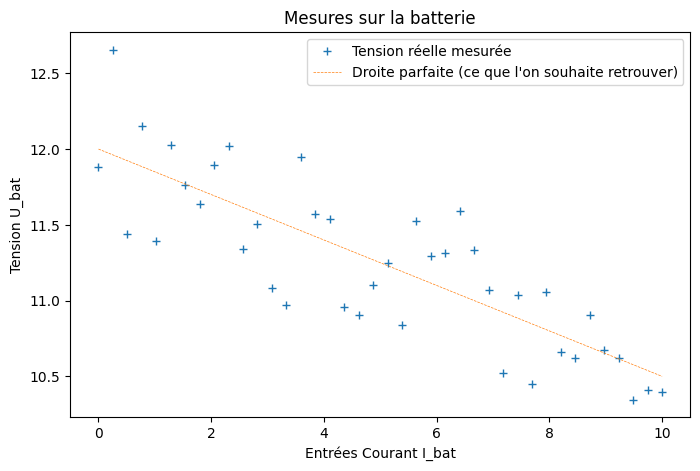

In [ ]:
# Affichage des mesures
fig,ax = plt.subplots(1,figsize=(8,5))
ax.plot (I_bat, U_mes, marker="+", linestyle="none", linewidth=1, label="Tension réelle mesurée")
ax.plot (I_bat, U_th, linestyle="--", linewidth=0.5, label="Droite parfaite (ce que l'on souhaite retrouver)")
ax.set_title("Mesures sur la batterie")
ax.set_xlabel("Entrées Courant I_bat")
ax.set_ylabel("Tension U_bat")
ax.legend()
plt.show()

**3. Recherche des paramètres de la batterie avec un neurone**

Un neurone artificiel (voir dessin ci-dessous) associe des poids w à chacune de ses entrées x (=caractéristiques), et ajoute un biais b. On peut ensuite ajouter une fonction d'activation f pour obtenir la sortie y (=étiquette). Si l'on prend une seule entrée, et pas de fonction d'activation, on retrouve le y = w * x + b de la partie 2 !

<div>
<img src="https://user.oc-static.com/upload/2018/12/10/15444553183515_neuroneformel-1.png" width="500"/>
</div>


Pour travailler avec un réseau de neurones, il faut commencer par **définir le réseau** : nombre de couches, type de couche, nombre de neurones par couches, ... Ici pour cette première approche un seul neurone est suffisant pour retrouver une équation y = w * x + b pour laquelle on espère obtenir après entrainement w = -Ri_th et b = E_th. La fonction d'activation f n'est pour l'instant pas utilisée.

In [ ]:
taux_apprentissage = 0.01   # "Vitesse" d'apprentissage. Par défaut 0.01

# Construction du réseau pour régression linéaire
mon_modele = tf.keras.models.Sequential()  # Définition d'un modèle de réseau séquentiel (= ensemble de couches)

# Description du réseau : ici 1 couche de 1 neurone, et pas de fonction d'activation
# Une couche "Dense" signifie une couche de neurones artificiels
# D'autres types de couches sont possibles : layers.Rescaling(), layers.Conv2D(), layers.MaxPooling2D(), layer.Dropout()... que l'on regardera par la suite
mon_modele.add(tf.keras.layers.Dense(units=1,             # unit = le nombre de sorties de la couche, donc le nombre de neurones
                                    input_shape=(1,)))    # 1 car la couche n'a qu'une seule entrée x (une valeur de courant I_bat) pour notre exercice

# Finalisation du réseau : on précise les paramètres d'apprentissage,  et
mon_modele.compile(optimizer=tf.keras.optimizers.experimental.RMSprop(learning_rate=taux_apprentissage),  # Le type d'optimiseur (RMSprop) et le taux d'apprentissage
                loss="mean_squared_error",                                                                # L'erreur à minimmiser : ici moyenne des distances au carré
                metrics=[tf.keras.metrics.RootMeanSquaredError()])                                        # Une grandeur quantifiant la qualité de l'apprentissage
                                                                                                    # Ici c'est directement la racine carré de l'erreur
                                                                                                    # (pour ceux qui sont à l'aise, c'est la valeur efficace de la distance)

On doit ensuite écrire le code pour **entrainer le réseau**.  
- On dispose pour cela d'exemples de couples entrées/sorties "connus", que nous utiliserons comme **base d'apprentissage**. Pour nous, un couple c'est une de nos mesures, c'est à dire une valeur de tension U_bat mesurée pour un courant I_bat donné. La base d'apprentissage, c'est donc les 40 mesures (40 tensions U_bat pour 40 courants I_bat) présentées précédemment.  
- "**Entrainer**", cela signifie modifier les poids w et les biais b des neurones afin que pour une entrée donnée la sortie soit la meilleure possible. Le réseau modifie au fur et à mesure les poids/biais à partir des données entrées/sortie que nous lui fournissons en exemple afin qu'au final ça "colle" au mieux à tous ces exemples.  

L'entrainement a besoin de plusieurs arguments qu'il faut bien comprendre :

In [ ]:
epochs=400                # Nombre d'itérations pour l'entrainement. Par défaut 400
batch=10                  # Nombre de caractéristiques (entrées) prises en compte dans une des étapes d'une epoch. Par défaut 10
                          # (donc ici 400/10 = 40 mises à jours des poids du modèles dans une epoch)

In [ ]:
# Entrainement du modèle par régression linéaire
# On fournit en arguments :
# - x : les "caractéristiques" d'entrée (features en anglais)
# - y : les "étiquettes" de sortie (label en anglais)
# - epochs : le nombre d'itérations de l'entrainement
# - batch_size : le nombre de caractéristiques prises en compte dans une itération (entre 1 et le nb total disponible)

history = mon_modele.fit(x=I_bat,     # Fonction TensorFlow d'entrainement du réseau
                        y=U_mes,
                        batch_size=batch,
                        epochs=epochs)

# Récupération des poids et biais calculés pour notre neurone
trained_weight = mon_modele.get_weights()[0]
trained_bias = mon_modele.get_weights()[1]

# Récupération de la liste des itérations
epochs = history.epoch

# Récupération de l'erreur pour chaque itération
rmse = pd.DataFrame(history.history)["root_mean_squared_error"]

Epoch 1/400
4/4 [==============================] - 2s 6ms/step - loss: 119.7163 - root_mean_squared_error: 10.9415
Epoch 2/400
4/4 [==============================] - 0s 4ms/step - loss: 111.0600 - root_mean_squared_error: 10.5385
Epoch 3/400
4/4 [==============================] - 0s 3ms/step - loss: 105.0210 - root_mean_squared_error: 10.2480
Epoch 4/400
4/4 [==============================] - 0s 3ms/step - loss: 99.8856 - root_mean_squared_error: 9.9943
Epoch 5/400
4/4 [==============================] - 0s 3ms/step - loss: 95.2864 - root_mean_squared_error: 9.7615
Epoch 6/400
4/4 [==============================] - 0s 3ms/step - loss: 90.9895 - root_mean_squared_error: 9.5388
Epoch 7/400
4/4 [==============================] - 0s 3ms/step - loss: 86.9771 - root_mean_squared_error: 9.3262
Epoch 8/400
4/4 [==============================] - 0s 3ms/step - loss: 83.1716 - root_mean_squared_error: 9.1198
Epoch 9/400
4/4 [==============================] - 0s 3ms/step - loss: 79.5397 - root_mean

A chaque itération, l'entrainement modifie plusieurs fois les poids/biais pour que le modèle s'améliore. Notez ici que l'on n'a pas fourni de direction de descente !

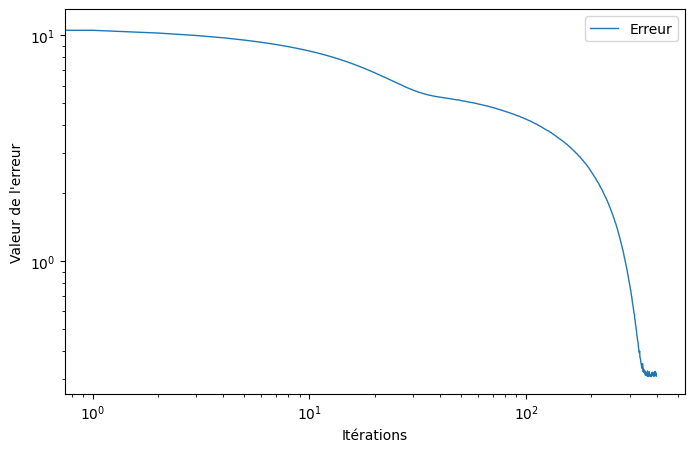

In [ ]:
#Affichage de l'évolution de l'erreur
fig,ax = plt.subplots(1,figsize=(8,5))
ax.plot (epochs,rmse, linestyle="-", linewidth=1, label="Erreur")
ax.set_xlabel("Itérations")
ax.set_ylabel("Valeur de l'erreur")
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
plt.show()

**4. Analyse des résultats du modèle**

Regardons ce que donne notre modèle pour l'intervale de courant ayant servi aux mesures :

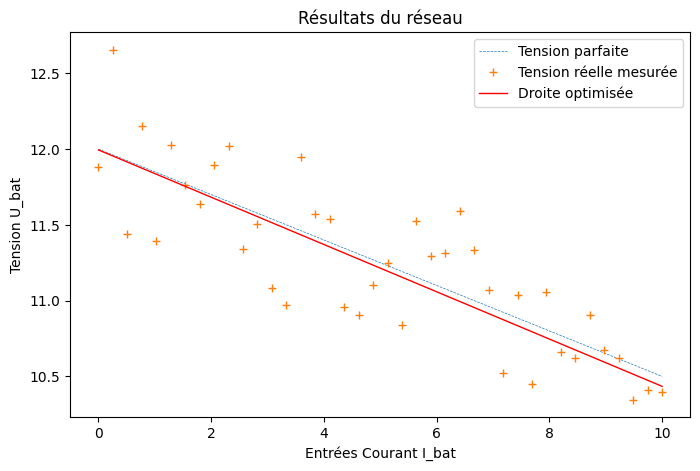

Les paramètres théoriques sont : E_th = 12V et Ri_th = 0.15ohms 
Les paramètres calculés par le modèle en 400 itérations sont E_mod = 11.9942255V et Ri_mod = 0.15600927ohms 


In [ ]:
# Analyse du modèle obtenu pour notre réseau après apprentissage
U_mod = trained_bias + (I_bat * trained_weight) # B + W * I_bat

# Affichage des résultats du modèle
# Affichage des résultats du modèle
fig,ax = plt.subplots(1,figsize=(8,5))
ax.plot (I_bat, U_th, linestyle="--", linewidth=0.5, label="Tension parfaite")
ax.plot (I_bat, U_mes, marker="+", linestyle="none", linewidth=1, label="Tension réelle mesurée")
ax.plot (I_bat, U_mod[0], linestyle="-", linewidth=1, color="red", label="Droite optimisée")
ax.set_title("Résultats du réseau")
ax.set_xlabel("Entrées Courant I_bat")
ax.set_ylabel("Tension U_bat")
ax.legend()
plt.show()

print ("Les paramètres théoriques sont : E_th = " + str(E_th) + "V et Ri_th = " + str(Ri_th) + "ohms ")
print ("Les paramètres calculés par le modèle en " + str(len(epochs)) + " itérations sont E_mod = " + str(trained_bias[0]) + "V et Ri_mod = " + str(-trained_weight[0][0]) + "ohms ")


La droite optimisée n'est pas si mauvaise, mais nous avons déjà obtenu des résultats similaires dans la partie 2... sauf qu'il faut se souvenir que là nous n'avons pas fourni l'expression de la pente : le réseau a appris tout seul, "sur le tas" !  
Le problème ici est aussi que les ordres de grandeurs des paramètres que l'on veut optimiser sont très différents : la valeur de la pente w est ~100x plus faible que le biais b car la résistance interne de la batterie est très faible. Les choses pourraient s'améliorer en normalisant les caractéristiques d'entrée, comme nous le verrons par la suite.  
Un autre point remarquable : il y a de l'aléatoire dans les résultats obtenus : comparez avec vos camarades, ou réentrainez le réseau et vous verrez que ce dernier obtiendra une autre droite !

**5. Utilisation du modèle sur des entrées de "test"**

Enfin, on teste généralement un réseau de neurones sur une base "non connue" (non utilisée pour l'apprentissage) afin de vérifier qu'il est capable de prédire une sortie pour une entrée qui n'a pas été apprise, par exemple ici pour un courant I_bat de 0.1 A, ou 10.6 A.  
Comment faire ces tests sur une entrée qui n'a pas servi à l'apprentissage ?

In [ ]:
# Prédiction sur des exemples non utilisés lors de l'apprentissage
x_test = [0.1, 1.4, 10.6]     # valeurs de I_bat courants tests
mon_modele.predict(x_test, verbose=0)

array([[11.978624],
       [11.775812],
       [10.340528]], dtype=float32)

In [ ]:
# Prédiction sur un exemple particulier de la liste
choix = 2                     # valeur de I_bat à tester
print ("Notre modèle IA dit que la tension de sortie U_bat vaut " + str(mon_modele.predict(x_test, verbose=0)[choix][0]) + " V pour un courant de " + str(x_test[choix]) + " A")

Notre modèle IA dit que la tension de sortie U_bat vaut 10.340528 V pour un courant de 10.6 A


Que pensez-vous de ces prédictions?

**6. Neurone à 2 entrées**

**Fabrication des grandeurs étudiées et modèle théorique**  
On considère pour la suite à obtenir un modèle un peu plus complexe de notre batterie : la tension obtenue ne dépend plus uniquement du courant mesuré, mais également de la température T du système. On a donc maintenant un système à 2 entrées (Ibat, T) et une sortie (U_bat)

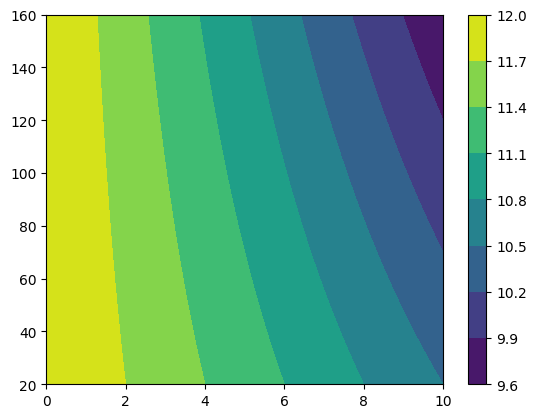

In [4]:
NI = 40                           # Nombre de mesures pour une température
NT = 70                           # Nombre de températures considérées
I_bat = np.linspace(0,10,num=NI)  # Fabrication d'un vecteur de NI points régulièrement espacés entre 0 et 10 (0, ..., 10 Ampères)
T = np.linspace(20,160,num=NT)  # Fabrication d'un vecteur de NT points régulièrement espacés entre 20 et 160 (20, ..., 160 °C)
xv, yv = np.meshgrid(I_bat, T)

# Définition de la fonction mathématique théorique.
# Le modèle que l'on va essayer de retrouver automatiquement est U_bat = E - Ri(T) * I_bat
# avec Ri(T) = Ri(T0)*(1+alpha(T-T0)) où T0 est la température initiale (20°) et alpha = 4.10^-3

alpha = 4e-3                   # coefficient thermique
T0 = 20                        # Température initiale
Ri_th = 0.15                   # Poids théorique si T = T0. Par défaut 0.15 ohms
E_th = 12                      # Biais théorique. Par défaut 12 V
U_th = E_th - Ri_th*(1+alpha*(yv-T0)) * xv    # Valeurs des tensions en fonction de I_bat et T

# Affichage de U_bat en fonction de I_bat et T
plt.contourf(I_bat, T, U_th)    # U_th est ici une matrice de dimension 70*40
plt.colorbar()
plt.show()


Notez que le modèle n'est pas linéaire : il contient en effet le produit des entrées Ri(T0) * alpha * T * I_bat.  
C'est donc cette allure de U_bat(I_bat, T) que l'on va essayer d'apprendre avec notre modèle u: des isovaleurs quasi verticales pour I faible, et dont la pente change pour I plus grand.

**Fabrication du dataset d'entrainement et du vecteur de sortie**  
Il nous faut dans un premier temps fabriquer le dataset des entrées, qui est un ensemble de couples (I_bat,T). Avec les vecteurs de courant (40 valeurs) et de température utilisés (70 valeurs), on veut fabriquer un dataset de 40*70 = 2800 couples :

In [17]:
# Obtention d'une table d'entrées à la bonne dimension
vecteur = np.arange(2*len(I_bat)*len(T), dtype=float)
table = vecteur.reshape((len(I_bat)* len(T)),2)   # Table de dimension (2800*2)...
table = np.zeros_like(table)                      # ... remplie de 0
table.shape                                       # Affichage de la taille pour vérification

(2800, 2)

Ensuite on y range toutes les combinaisons de couple d'entrées (I_bat, T) possibles :

In [19]:
for i in range(0,len(T)):
  for j in range(0,len(I_bat)):
    table[len(I_bat)*i+j][0] = I_bat[j]   # Première entrée du couple
    table[len(I_bat)*i+j][1] = T[i]       # 2nde entrée du couple
table

array([[  0.        ,  20.        ],
       [  0.25641026,  20.        ],
       [  0.51282051,  20.        ],
       ...,
       [  9.48717949, 160.        ],
       [  9.74358974, 160.        ],
       [ 10.        , 160.        ]])

Et on met le tout dans le format dataset de TensorFlow :

In [7]:
dataset = tf.data.Dataset.from_tensor_slices(table)

On fabrique ensuite le vecteur des sorties associées (on les a déjà calculées précédemment dans la matrice U_th) :

In [8]:
# Obtention d'un vecteur sortie à la bonne dimension
sortie = np.arange(len(I_bat)*len(T), dtype=float)
sortie = sortie.reshape((len(I_bat)* len(T)),1)
sortie = np.zeros_like(sortie)

for i in range(0,len(T)):
  for j in range(0,len(I_bat)):
    sortie[len(I_bat)*i+j] = U_th[i][j]
sortie

array([[12.        ],
       [11.96153846],
       [11.92307692],
       ...,
       [ 9.78      ],
       [ 9.72      ],
       [ 9.66      ]])

**Mise en place d'un nouveau réseau à 1 neurones, 2 entrées et entrainement**  
Définition du nouveau d'un nouveau réseau, pour l'instant assez similaire au précédent mais avec 2 entrées :

In [ ]:
taux_apprentissage = 0.01   # "Vitesse" d'apprentissage. Par défaut 0.01

# Construction du réseau pour régression linéaire
mon_modele2 = tf.keras.models.Sequential()  # Définition d'un modèle de réseau séquentiel (= ensemble de couches)

# Description du réseau : ici 1 couche de 1 neurone, et pas de fonction d'activation
# Une couche "Dense" signifie une couche de neurones artificiels
# D'autres types de couches sont possibles : layers.Rescaling(), layers.Conv2D(), layers.MaxPooling2D(), layer.Dropout()... que l'on regardera par la suite
mon_modele2.add(tf.keras.layers.Dense(units=1,             # unit = le nombre de sorties de la couche, donc le nombre de neurones
                                    input_shape=(2,)))    # 2 car la couche a deux entrées x (une valeur de courant I_bat et une température T)

# Finalisation du réseau : on précise les paramètres d'apprentissage,  et
mon_modele2.compile(optimizer=tf.keras.optimizers.experimental.RMSprop(learning_rate=taux_apprentissage),  # Le type d'optimiseur (RMSprop) et le taux d'apprentissage
                loss="mean_squared_error",                                                                # L'erreur à minimmiser : ici moyenne des distances au carré
                metrics=[tf.keras.metrics.RootMeanSquaredError()])                                        # Une grandeur quantifiant la qualité de l'apprentissage
                                                                                                          # Ici c'est directement la racine carré de l'erreur

Nouvelle partie concernant l'entrainement :

In [ ]:
epochs=50                 # Nombre d'itérations pour l'entrainement. Par défaut 50
batch=32                  # Nombre de caractéristiques (entrées) prises en compte dans une des étapes d'une epoch. Par défaut 32
                          # (donc ici 2800/32 = 400 mises à jours des poids du modèles dans une epoch)

# Entrainement du modèle par régression linéaire
# On fournit en arguments :
# - x : les "caractéristiques" d'entrée (features en anglais)
# - y : les "étiquettes" de sortie (label en anglais)
# - epochs : le nombre d'itérations de l'entrainement
# - batch_size : le nombre de caractéristiques prises en compte dans une itération (entre 1 et le nb total disponible)

history = mon_modele2.fit(x=table,     # Fonction TensorFlow d'entrainement du réseau
                        y=sortie,
                        batch_size=batch,
                        epochs=epochs)

# Récupération des poids et biais calculés pour notre neurone
trained_weight = mon_modele2.get_weights()[0]
trained_bias = mon_modele2.get_weights()[1]

# Récupération de la liste des itérations
epochs = history.epoch

# Récupération de l'erreur pour chaque itération
rmse = pd.DataFrame(history.history)["root_mean_squared_error"]


Epoch 1/50
88/88 [==============================] - 1s 3ms/step - loss: 362.7871 - root_mean_squared_error: 19.0470
Epoch 2/50
88/88 [==============================] - 0s 3ms/step - loss: 50.2335 - root_mean_squared_error: 7.0876
Epoch 3/50
88/88 [==============================] - 0s 2ms/step - loss: 24.0315 - root_mean_squared_error: 4.9022
Epoch 4/50
88/88 [==============================] - 0s 2ms/step - loss: 14.0312 - root_mean_squared_error: 3.7458
Epoch 5/50
88/88 [==============================] - 0s 3ms/step - loss: 11.6159 - root_mean_squared_error: 3.4082
Epoch 6/50
88/88 [==============================] - 0s 3ms/step - loss: 10.0515 - root_mean_squared_error: 3.1704
Epoch 7/50
88/88 [==============================] - 0s 2ms/step - loss: 8.5724 - root_mean_squared_error: 2.9279
Epoch 8/50
88/88 [==============================] - 0s 2ms/step - loss: 7.2763 - root_mean_squared_error: 2.6975
Epoch 9/50
88/88 [==============================] - 0s 3ms/step - loss: 6.2593 - root_me

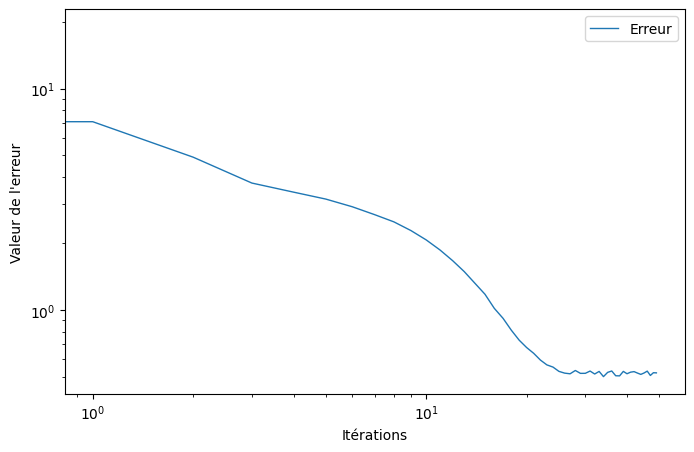

In [ ]:
#Affichage de l'évolution de l'erreur
fig,ax = plt.subplots(1,figsize=(8,5))
ax.plot (epochs,rmse, linestyle="-", linewidth=1, label="Erreur")
ax.set_xlabel("Itérations")
ax.set_ylabel("Valeur de l'erreur")
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
plt.show()

**Analyse des résultats du modèle à 1 neurone**  
L'erreur semble rester assez élevée... analysons les résultats :

In [ ]:
# Tensions obtenues par le modèle sur la base d'entrainement
U_mod2 = mon_modele2.predict(table, verbose=0)

# Que l'on remet en format matrice 70*40 pour affichage
U_mod2 = U_mod2.reshape(len(T),len(I_bat))
U_mod2.shape

(70, 40)

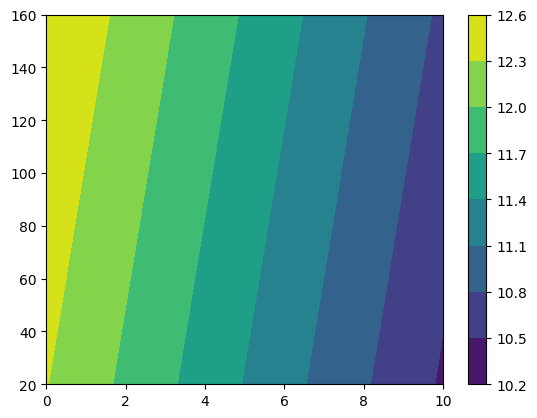

In [ ]:
# Affichage de U_mod obtenu par le modèle 2 en fonction de I_bat et T
plt.contourf(I_bat, T, U_mod2)
plt.colorbar()
plt.show()

On voit que le modèle est loin d'être optimal : l'allure globale de U_bat ressemble de loin à ce qui est attendu, mais l'évolution est linéaire et les valeurs des tensions non respectées. En fait, avec un seul neurone, il y a "trop" de choses à apprendre.
  
**Etude d'un réseau avec une couche de 8 neurones artificiels**    
Essayons un nouveau réseau avec plus de neurones. Comme nous n'avons qu'une seule sortie, la dernière couche ne doit contenir qu'un seul neurone, et il faut donc ajouter une "couche cachée" qui contient les 8 neurones.

In [ ]:
taux_apprentissage = 0.01   # "Vitesse" d'apprentissage. Par défaut 0.01

# Construction du réseau
mon_modele3 = tf.keras.models.Sequential()  # Définition d'un modèle de réseau séquentiel (= ensemble de couches)

# Description du réseau : ici 1 couche cachée de 8 neurones et 1 couche de sortie à 1 neurone. Pas de fonction d'activation

# Ajout d'une première couche cachée de 8 neurones
mon_modele3.add(tf.keras.layers.Dense(units=8, input_shape=(2,)))    # Par defaut unit = 8, et input = 2 car 2 entrées

# Ajout de la couche de sortie à 1 neurone
mon_modele3.add(tf.keras.layers.Dense(units=1,            # unit = le nombre de sorties de la couche, donc le nombre de neurones
                                    input_shape=(8,)))    # 8 car la couche a 8 entrées x qui sont les sorties des 8 neurones précédents

# Finalisation du réseau : on précise les paramètres d'apprentissage,  et
mon_modele3.compile(optimizer=tf.keras.optimizers.experimental.RMSprop(learning_rate=taux_apprentissage),  # Le type d'optimiseur (RMSprop) et le taux d'apprentissage
                loss="mean_squared_error",                                                                # L'erreur à minimmiser : ici moyenne des distances au carré
                metrics=[tf.keras.metrics.RootMeanSquaredError()])                                        # Une grandeur quantifiant la qualité de l'apprentissage
                                                                                                          # Ici c'est directement la racine carré de l'erreur

In [ ]:
epochs=100                # Nombre d'itérations pour l'entrainement. Par défaut 100
batch=32                  # Nombre de caractéristiques (entrées) prises en compte dans une des étapes d'une epoch. Par défaut 32
                          # (donc ici 2800/32 = 400 mises à jours des poids du modèles dans une epoch)

# Entrainement du modèle par régression linéaire
# On fournit en arguments :
# - x : les "caractéristiques" d'entrée (features en anglais)
# - y : les "étiquettes" de sortie (label en anglais)
# - epochs : le nombre d'itérations de l'entrainement
# - batch_size : le nombre de caractéristiques prises en compte dans une itération (entre 1 et le nb total disponible)

history = mon_modele3.fit(x=table,     # Fonction TensorFlow d'entrainement du réseau
                        y=sortie,
                        batch_size=batch,
                        epochs=epochs)

# Récupération des poids et biais calculés pour notre neurone
trained_weight = mon_modele3.get_weights()[0]
trained_bias = mon_modele3.get_weights()[1]

# Récupération de la liste des itérations
epochs = history.epoch

# Récupération de l'erreur pour chaque itération
rmse = pd.DataFrame(history.history)["root_mean_squared_error"]

Epoch 1/100
88/88 [==============================] - 1s 3ms/step - loss: 38.4951 - root_mean_squared_error: 6.2044
Epoch 2/100
88/88 [==============================] - 0s 3ms/step - loss: 17.6026 - root_mean_squared_error: 4.1955
Epoch 3/100
88/88 [==============================] - 0s 4ms/step - loss: 14.1368 - root_mean_squared_error: 3.7599
Epoch 4/100
88/88 [==============================] - 0s 4ms/step - loss: 11.1784 - root_mean_squared_error: 3.3434
Epoch 5/100
88/88 [==============================] - 0s 4ms/step - loss: 8.8395 - root_mean_squared_error: 2.9731
Epoch 6/100
88/88 [==============================] - 0s 4ms/step - loss: 7.6460 - root_mean_squared_error: 2.7651
Epoch 7/100
88/88 [==============================] - 0s 4ms/step - loss: 6.0818 - root_mean_squared_error: 2.4661
Epoch 8/100
88/88 [==============================] - 0s 4ms/step - loss: 5.3211 - root_mean_squared_error: 2.3068
Epoch 9/100
88/88 [==============================] - 0s 4ms/step - loss: 4.6122 - ro

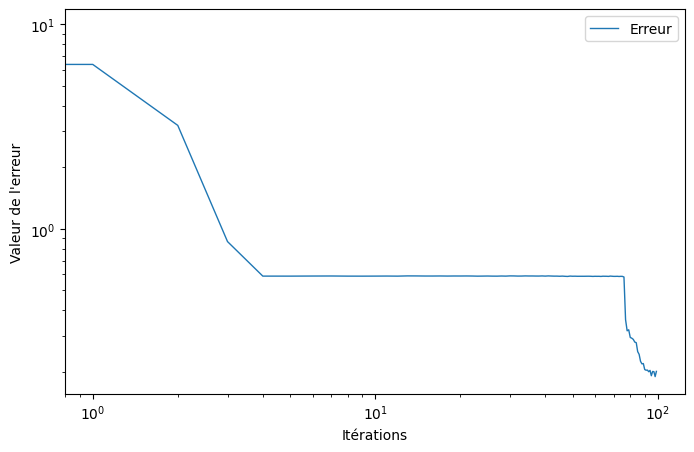

In [ ]:
#Affichage de l'évolution de l'erreur
fig,ax = plt.subplots(1,figsize=(8,5))
ax.plot (epochs,rmse, linestyle="-", linewidth=1, label="Erreur")
ax.set_xlabel("Itérations")
ax.set_ylabel("Valeur de l'erreur")
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
plt.show()

**Test du réseau à une couche carchée de 8 neurones**  
On teste ce nouveau modèle sur la base d'apprentissage :

In [ ]:
U_mod3 = mon_modele3.predict(table, verbose=0)
U_mod3 = U_mod3.reshape(len(T),len(I_bat))

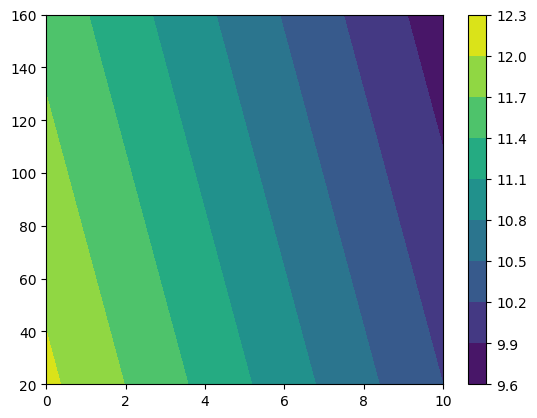

In [ ]:
# Affichage de U_bat obtenu par le modèle 3 en fonction de I_bat et T
plt.contourf(I_bat, T, U_mod3)
plt.colorbar()
plt.show()

C'est un peu mieux au niveau des amplitudes de tension, mais on voit que les évolutions restent "linéaires". Il faudrait introduire une "non-linéarité". Les parties suivantes propose deux approches pour y parvenir.

**Gestion des non-linéarités par fonction d'activation**  
Une possibilité est d'intégrer une fonction d'activation non-linéaire. Testons ce que donne la fonction ReLU :

In [ ]:
taux_apprentissage = 0.01   # "Vitesse" d'apprentissage. Par défaut 0.01

# Construction du réseau
mon_modele4 = tf.keras.models.Sequential()  # Définition d'un modèle de réseau séquentiel (= ensemble de couches)

# Description du réseau : ici 1 couche cachée de 8 neurones et 1 couche de sortie à 1 neurone. Fonction d'activation ReLU

# Ajout d'une première couche cachée de 8 neurones
mon_modele4.add(tf.keras.layers.Dense(units=8, activation='relu', input_shape=(2,)))    # Par defaut unit = 8, et input = 2 car 2 entrées

# Ajout de la couche de sortie à 1 neurone
mon_modele4.add(tf.keras.layers.Dense(units=1,            # unit = le nombre de sorties de la couche, donc le nombre de neurones
                                    input_shape=(8,)))    # 8 car la couche a 8 entrées x qui sont les sorties des 8 neurones précédents

# Finalisation du réseau : on précise les paramètres d'apprentissage,  et
mon_modele4.compile(optimizer=tf.keras.optimizers.experimental.RMSprop(learning_rate=taux_apprentissage),  # Le type d'optimiseur (RMSprop) et le taux d'apprentissage
                loss="mean_squared_error",                                                                # L'erreur à minimmiser : ici moyenne des distances au carré
                metrics=[tf.keras.metrics.RootMeanSquaredError()])                                        # Une grandeur quantifiant la qualité de l'apprentissage
                                                                                                          # Ici c'est directement la racine carré de l'erreur

In [ ]:
epochs=100                # Nombre d'itérations pour l'entrainement. Par défaut 100
batch=32                  # Nombre de caractéristiques (entrées) prises en compte dans une des étapes d'une epoch. Par défaut 32
                          # (donc ici 2800/32 = 400 mises à jours des poids du modèles dans une epoch)

# Entrainement du modèle par régression linéaire
# On fournit en arguments :
# - x : les "caractéristiques" d'entrée (features en anglais)
# - y : les "étiquettes" de sortie (label en anglais)
# - epochs : le nombre d'itérations de l'entrainement
# - batch_size : le nombre de caractéristiques prises en compte dans une itération (entre 1 et le nb total disponible)

history = mon_modele4.fit(x=table,     # Fonction TensorFlow d'entrainement du réseau
                        y=sortie,
                        batch_size=batch,
                        epochs=epochs)

# Récupération des poids et biais calculés pour notre neurone
trained_weight = mon_modele4.get_weights()[0]
trained_bias = mon_modele4.get_weights()[1]

# Récupération de la liste des itérations
epochs = history.epoch

# Récupération de l'erreur pour chaque itération
rmse = pd.DataFrame(history.history)["root_mean_squared_error"]

Epoch 1/800
88/88 [==============================] - 0s 3ms/step - loss: 0.0812 - root_mean_squared_error: 0.2850
Epoch 2/800
88/88 [==============================] - 0s 3ms/step - loss: 0.0752 - root_mean_squared_error: 0.2743
Epoch 3/800
88/88 [==============================] - 0s 3ms/step - loss: 0.0734 - root_mean_squared_error: 0.2709
Epoch 4/800
88/88 [==============================] - 0s 3ms/step - loss: 0.0752 - root_mean_squared_error: 0.2742
Epoch 5/800
88/88 [==============================] - 0s 3ms/step - loss: 0.0685 - root_mean_squared_error: 0.2618
Epoch 6/800
88/88 [==============================] - 0s 3ms/step - loss: 0.0710 - root_mean_squared_error: 0.2665
Epoch 7/800
88/88 [==============================] - 0s 3ms/step - loss: 0.0667 - root_mean_squared_error: 0.2583
Epoch 8/800
88/88 [==============================] - 0s 3ms/step - loss: 0.0639 - root_mean_squared_error: 0.2528
Epoch 9/800
88/88 [==============================] - 0s 3ms/step - loss: 0.0628 - root_m

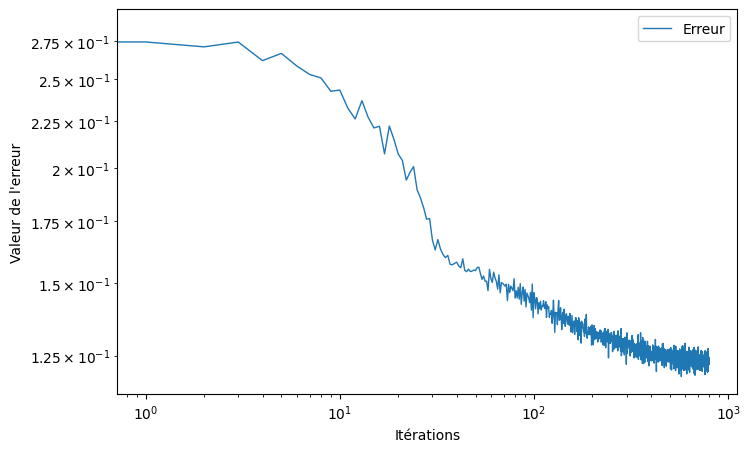

In [ ]:
#Affichage de l'évolution de l'erreur
fig,ax = plt.subplots(1,figsize=(8,5))
ax.plot (epochs,rmse, linestyle="-", linewidth=1, label="Erreur")
ax.set_xlabel("Itérations")
ax.set_ylabel("Valeur de l'erreur")
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
plt.show()

Test de ce modèle avec fonction ReLU sur la base d'apprentissage :

In [ ]:
U_mod4 = mon_modele4.predict(table, verbose=0)
U_mod4 = U_mod4.reshape(len(T),len(I_bat))

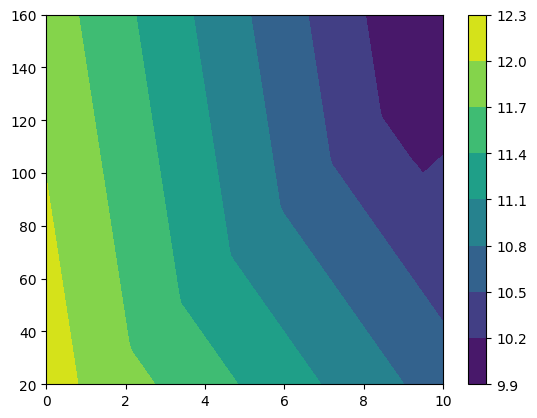

In [ ]:
# Affichage de U_bat obtenu par le modèle 4 en fonction de I_bat et T
plt.contourf(I_bat, T, U_mod4)
plt.colorbar()
plt.show()

Le modèle n'est toujours pas parfait, mais (normalement) on observe bien une non-linéarité : ça va donc dans le bon sens ! Par contre, la non-linéarité apparait à travers des isovaleurs "anguleuses", ce qui est probablement lié au format de la fonction ReLU.  
Note : si la non-linéarité n'est pas observable, refaire un entrainement.

Il existe d'autres fonctions d'activation, essayons celle appelée ELU, qui est une version plus douce (en math on dirait de classe C1) basée sur la ReLU. Attention, cette fonction peut allonger les temps d'entrainement.

In [15]:
taux_apprentissage = 0.01   # "Vitesse" d'apprentissage. Par défaut 0.01

# Construction du réseau
mon_modele5 = tf.keras.models.Sequential()  # Définition d'un modèle de réseau séquentiel (= ensemble de couches)

# Description du réseau : ici 1 couche cachée de 8 neurones et 1 couche de sortie à 1 neurone. Fonction d'activation ReLU

# Ajout d'une première couche cachée de 8 neurones
mon_modele5.add(tf.keras.layers.Dense(units=8, activation='elu', input_shape=(2,)))    # Par defaut unit = 8, et input = 2 car 2 entrées
# Ajout d'une première couche cachée de 8 neurones
#mon_modele5.add(tf.keras.layers.Dense(units=32, activation='elu', input_shape=(32,)))    # Par defaut unit = 8, et input = 2 car 2 entrées
# Ajout d'une première couche cachée de 8 neurones
#mon_modele5.add(tf.keras.layers.Dense(units=16, activation='elu', input_shape=(32,)))    # Par defaut unit = 8, et input = 2 car 2 entrées

# Ajout de la couche de sortie à 1 neurone
mon_modele5.add(tf.keras.layers.Dense(units=1,            # unit = le nombre de sorties de la couche, donc le nombre de neurones
                                    input_shape=(8,)))    # 8 car la couche a 8 entrées x qui sont les sorties des 8 neurones précédents

# Finalisation du réseau : on précise les paramètres d'apprentissage,  et
mon_modele5.compile(optimizer=tf.keras.optimizers.experimental.RMSprop(learning_rate=taux_apprentissage),  # Le type d'optimiseur (RMSprop) et le taux d'apprentissage
                loss="mean_squared_error",                                                                # L'erreur à minimmiser : ici moyenne des distances au carré
                metrics=[tf.keras.metrics.RootMeanSquaredError()])                                        # Une grandeur quantifiant la qualité de l'apprentissage
                                                                                                          # Ici c'est directement la racine carré de l'erreur

epochs=100                # Nombre d'itérations pour l'entrainement. Par défaut 100
batch=32                  # Nombre de caractéristiques (entrées) prises en compte dans une des étapes d'une epoch. Par défaut 32
                          # (donc ici 2800/32 = 400 mises à jours des poids du modèles dans une epoch)

# Entrainement du modèle par régression linéaire
# On fournit en arguments :
# - x : les "caractéristiques" d'entrée (features en anglais)
# - y : les "étiquettes" de sortie (label en anglais)
# - epochs : le nombre d'itérations de l'entrainement
# - batch_size : le nombre de caractéristiques prises en compte dans une itération (entre 1 et le nb total disponible)

history = mon_modele5.fit(x=table,     # Fonction TensorFlow d'entrainement du réseau
                        y=sortie,
                        batch_size=batch,
                        epochs=epochs)

# Récupération des poids et biais calculés pour notre neurone
trained_weight = mon_modele5.get_weights()[0]
trained_bias = mon_modele5.get_weights()[1]

# Récupération de la liste des itérations
epochs = history.epoch

# Récupération de l'erreur pour chaque itération
rmse = pd.DataFrame(history.history)["root_mean_squared_error"]

Epoch 1/100
88/88 [==============================] - 1s 3ms/step - loss: 14.8350 - root_mean_squared_error: 3.8516
Epoch 2/100
88/88 [==============================] - 0s 3ms/step - loss: 7.8888 - root_mean_squared_error: 2.8087
Epoch 3/100
88/88 [==============================] - 0s 3ms/step - loss: 4.6773 - root_mean_squared_error: 2.1627
Epoch 4/100
88/88 [==============================] - 0s 3ms/step - loss: 3.1182 - root_mean_squared_error: 1.7658
Epoch 5/100
88/88 [==============================] - 0s 3ms/step - loss: 2.0503 - root_mean_squared_error: 1.4319
Epoch 6/100
88/88 [==============================] - 0s 3ms/step - loss: 1.4342 - root_mean_squared_error: 1.1976
Epoch 7/100
88/88 [==============================] - 0s 3ms/step - loss: 1.1116 - root_mean_squared_error: 1.0543
Epoch 8/100
88/88 [==============================] - 0s 3ms/step - loss: 0.8440 - root_mean_squared_error: 0.9187
Epoch 9/100
88/88 [==============================] - 0s 3ms/step - loss: 0.7470 - root_

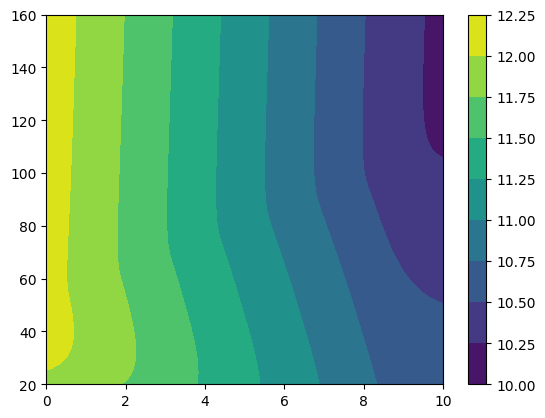

In [16]:
U_mod5 = mon_modele5.predict(table, verbose=0)
U_mod5 = U_mod5.reshape(len(T),len(I_bat))

# Affichage de U_bat obtenu par le modèle 4 en fonction de I_bat et T
plt.contourf(I_bat, T, U_mod5)
plt.colorbar()
plt.show()

Conclure sur l'utilisation des fonctions d'activation.

**Gestion des non-linéarités par pré-traitement des données**  
Une autre possibilité de gérer la non-linéarité est d'intégrer un pré-traitement des données avant de faire l'apprentissage. On a vu précédemment que le modèle contient un terme produit des deux entrées. On peut donc intégrer ce produit comme une entrée supplémentaire.  
Pour cela, il faut uniquement changer la table des entrées :

In [18]:
# Obtention d'une table d'entrées à la bonne dimension
vecteur = np.arange(3*len(I_bat)*len(T), dtype=float)
table2 = vecteur.reshape((len(I_bat)* len(T)),3)   # Table de dimension (2800*3)...
table2 = np.zeros_like(table2)                      # ... remplie de 0
table2.shape                                       # Affichage de la taille pour vérification

(2800, 3)

In [20]:
for i in range(0,len(T)):
  for j in range(0,len(I_bat)):
    table2[len(I_bat)*i+j][0] = I_bat[j]   # Première entrée du couple
    table2[len(I_bat)*i+j][1] = T[i]       # 2nde entrée du couple
    table2[len(I_bat)*i+j][2] = I_bat[j]*T[i]  # Ajout du produit des 2 entrées
table2

array([[0.00000000e+00, 2.00000000e+01, 0.00000000e+00],
       [2.56410256e-01, 2.00000000e+01, 5.12820513e+00],
       [5.12820513e-01, 2.00000000e+01, 1.02564103e+01],
       ...,
       [9.48717949e+00, 1.60000000e+02, 1.51794872e+03],
       [9.74358974e+00, 1.60000000e+02, 1.55897436e+03],
       [1.00000000e+01, 1.60000000e+02, 1.60000000e+03]])

On modifie alors très légèrement notre dernier modèle pour tenir compte de cette nouvelle entrée (le fonction ELU a été enlevée).

In [24]:
taux_apprentissage = 0.01   # "Vitesse" d'apprentissage. Par défaut 0.01

# Construction du réseau
mon_modele6 = tf.keras.models.Sequential()  # Définition d'un modèle de réseau séquentiel (= ensemble de couches)

# Description du réseau : ici 1 couche cachée de 8 neurones et 1 couche de sortie à 1 neurone. Fonction d'activation ReLU

# Ajout d'une première couche cachée de 8 neurones
mon_modele6.add(tf.keras.layers.Dense(units=8, input_shape=(3,)))    # Par defaut unit = 8, et input = 3 car 3 entrées
# Ajout d'une première couche cachée de 8 neurones
#mon_modele5.add(tf.keras.layers.Dense(units=32, activation='elu', input_shape=(32,)))    # Par defaut unit = 8, et input = 2 car 2 entrées
# Ajout d'une première couche cachée de 8 neurones
#mon_modele5.add(tf.keras.layers.Dense(units=16, activation='elu', input_shape=(32,)))    # Par defaut unit = 8, et input = 2 car 2 entrées

# Ajout de la couche de sortie à 1 neurone
mon_modele6.add(tf.keras.layers.Dense(units=1,            # unit = le nombre de sorties de la couche, donc le nombre de neurones
                                    input_shape=(8,)))    # 8 car la couche a 8 entrées x qui sont les sorties des 8 neurones précédents

# Finalisation du réseau : on précise les paramètres d'apprentissage,  et
mon_modele6.compile(optimizer=tf.keras.optimizers.experimental.RMSprop(learning_rate=taux_apprentissage),  # Le type d'optimiseur (RMSprop) et le taux d'apprentissage
                loss="mean_squared_error",                                                                # L'erreur à minimmiser : ici moyenne des distances au carré
                metrics=[tf.keras.metrics.RootMeanSquaredError()])                                        # Une grandeur quantifiant la qualité de l'apprentissage
                                                                                                          # Ici c'est directement la racine carré de l'erreur

epochs=100                # Nombre d'itérations pour l'entrainement. Par défaut 100
batch=32                  # Nombre de caractéristiques (entrées) prises en compte dans une des étapes d'une epoch. Par défaut 32
                          # (donc ici 2800/32 = 400 mises à jours des poids du modèles dans une epoch)

# Entrainement du modèle par régression linéaire
# On fournit en arguments :
# - x : les "caractéristiques" d'entrée (features en anglais)
# - y : les "étiquettes" de sortie (label en anglais)
# - epochs : le nombre d'itérations de l'entrainement
# - batch_size : le nombre de caractéristiques prises en compte dans une itération (entre 1 et le nb total disponible)

history = mon_modele6.fit(x=table2,     # Fonction TensorFlow d'entrainement du réseau
                        y=sortie,
                        batch_size=batch,
                        epochs=epochs)

# Récupération des poids et biais calculés pour notre neurone
trained_weight = mon_modele6.get_weights()[0]
trained_bias = mon_modele6.get_weights()[1]

# Récupération de la liste des itérations
epochs = history.epoch

# Récupération de l'erreur pour chaque itération
rmse = pd.DataFrame(history.history)["root_mean_squared_error"]

Epoch 1/100
88/88 [==============================] - 1s 3ms/step - loss: 22984.4941 - root_mean_squared_error: 151.6064
Epoch 2/100
88/88 [==============================] - 0s 3ms/step - loss: 442.2963 - root_mean_squared_error: 21.0308
Epoch 3/100
88/88 [==============================] - 0s 3ms/step - loss: 448.9428 - root_mean_squared_error: 21.1883
Epoch 4/100
88/88 [==============================] - 0s 3ms/step - loss: 419.3595 - root_mean_squared_error: 20.4783
Epoch 5/100
88/88 [==============================] - 0s 3ms/step - loss: 380.2485 - root_mean_squared_error: 19.5000
Epoch 6/100
88/88 [==============================] - 0s 3ms/step - loss: 328.6023 - root_mean_squared_error: 18.1274
Epoch 7/100
88/88 [==============================] - 0s 3ms/step - loss: 304.9581 - root_mean_squared_error: 17.4631
Epoch 8/100
88/88 [==============================] - 0s 4ms/step - loss: 246.7008 - root_mean_squared_error: 15.7067
Epoch 9/100
88/88 [==============================] - 0s 4ms/s

Et on le teste sur la bse d'apprentissage :

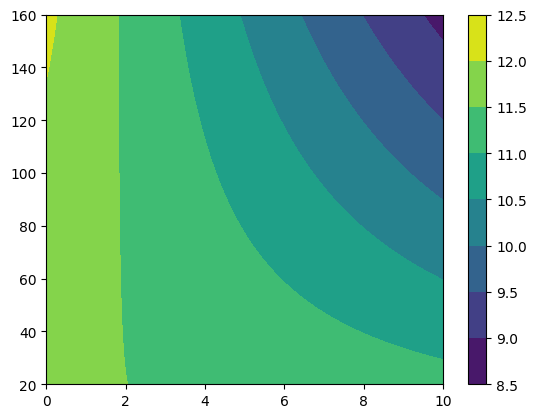

In [25]:
U_mod6 = mon_modele6.predict(table2, verbose=0)
U_mod6 = U_mod6.reshape(len(T),len(I_bat))

# Affichage de U_bat obtenu par le modèle 4 en fonction de I_bat et T
plt.contourf(I_bat, T, U_mod6)
plt.colorbar()
plt.show()

On voit bien ici que même sans fontion d'activation on a obtenu un modèle capable de considérer des non-linéairités.

**A vous de jouer !**  
Essayez d'obtenir le meilleur réseau possible en jouant sur :  
- le type de fonction d'activation
- le pré-traitement
- le nombre de couches et le nombre de neurones par couches
- les paramètres de batch/epoch...

Jouer avec une batterie c'est sympa... mais ça limite un peu les choses ! => la suite au prochain épisode !